In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    ##featurewise_center=True,
    #featurewise_std_normalization=True, 
    rotation_range=25.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=64)

Using TensorFlow backend.


In [5]:
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 


pre_trained_vgg = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
pre_trained_vgg.trainable = True
pre_trained_vgg.summary()

W0606 15:46:15.351002   512 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0606 15:46:15.369006   512 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0606 15:46:15.374017   512 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0606 15:46:15.403023   512 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 4100      
Total params: 127,972,164
Trainable params: 127,972,164
Non-trainable params: 0
______________________________________________________________

In [7]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='vgg16_trainable_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [8]:
from keras import backend as K
import tensorflow as tf

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [9]:
additional_model.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.RMSprop(lr=2e-5), 
                         metrics=['acc', auc, precision, recall, f1score])

W0606 15:46:15.713203   512 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0606 15:46:15.721215   512 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0606 15:46:15.809566   512 deprecation.py:323] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\tensorflow\python\ops\metrics_impl.py:809: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
W0606 15:46:15.849774   512 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use

In [10]:
X.shape

(2861, 224, 224, 3)

In [11]:
# history1=myvgg.fit(X,y,batch_size=32,
#                   epochs=100,
#                   validation_split=0.3,
#                   callbacks=[checkpoint])

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=150, 
            epochs=100, 
            validation_data=(X_val,y_val), 
            validation_steps=16, 
            callbacks=[checkpoint])

W0606 15:46:20.594078   512 deprecation.py:323] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 91s - loss: 1.1105 - acc: 0.4659 - auc: 0.6907 - precision: 0.4695 - recall: 0.1990 - f1score: 0.2660 - val_loss: 1.0070 - val_acc: 0.5239 - val_auc: 0.7703 - val_precision: 0.6181 - val_recall: 0.3050 - val_f1score: 0.4073
Epoch 2/100
 - 81s - loss: 0.9124 - acc: 0.5343 - auc: 0.7913 - precision: 0.6072 - recall: 0.3839 - f1score: 0.4662 - val_loss: 0.8879 - val_acc: 0.5367 - val_auc: 0.8064 - val_precision: 0.5931 - val_recall: 0.4529 - val_f1score: 0.5132
Epoch 3/100
 - 82s - loss: 0.8524 - acc: 0.5490 - auc: 0.8153 - precision: 0.6007 - recall: 0.4366 - f1score: 0.5036 - val_loss: 0.8720 - val_acc: 0.5192 - val_auc: 0.8221 - val_precision: 0.5667 - val_recall: 0.4098 - val_f1score: 0.4749
Epoch 4/100
 - 83s - loss: 0.8097 - acc: 0.5586 - auc: 0.8276 - precision: 0.6023 - recall: 0.4658 - f1score: 0.5239 - val_loss: 0.8898 - val_acc: 0.5355 - val_auc: 0.8322 - val_precision: 0.5835 - val_recall: 0.4482 - val_f1score: 0.5063
Epoch 5/100
 - 82s - loss: 0.7883 - acc: 0.5

Epoch 36/100
 - 83s - loss: 0.5774 - acc: 0.6786 - auc: 0.8904 - precision: 0.6825 - recall: 0.6686 - f1score: 0.6754 - val_loss: 0.6843 - val_acc: 0.6310 - val_auc: 0.8908 - val_precision: 0.6341 - val_recall: 0.6251 - val_f1score: 0.6296
Epoch 37/100
 - 83s - loss: 0.5720 - acc: 0.6790 - auc: 0.8912 - precision: 0.6844 - recall: 0.6696 - f1score: 0.6769 - val_loss: 0.6916 - val_acc: 0.6403 - val_auc: 0.8916 - val_precision: 0.6438 - val_recall: 0.6321 - val_f1score: 0.6379
Epoch 38/100
 - 83s - loss: 0.5704 - acc: 0.6835 - auc: 0.8920 - precision: 0.6880 - recall: 0.6760 - f1score: 0.6819 - val_loss: 0.9949 - val_acc: 0.5739 - val_auc: 0.8924 - val_precision: 0.5956 - val_recall: 0.5658 - val_f1score: 0.5802
Epoch 39/100
 - 83s - loss: 0.5577 - acc: 0.6960 - auc: 0.8928 - precision: 0.6997 - recall: 0.6887 - f1score: 0.6941 - val_loss: 0.7707 - val_acc: 0.5588 - val_auc: 0.8933 - val_precision: 0.5715 - val_recall: 0.5553 - val_f1score: 0.5632
Epoch 40/100
 - 83s - loss: 0.5604 - acc

Epoch 71/100
 - 83s - loss: 0.3583 - acc: 0.8343 - auc: 0.9203 - precision: 0.8347 - recall: 0.8327 - f1score: 0.8337 - val_loss: 0.9443 - val_acc: 0.6484 - val_auc: 0.9207 - val_precision: 0.6487 - val_recall: 0.6473 - val_f1score: 0.6480
Epoch 72/100
 - 83s - loss: 0.3456 - acc: 0.8385 - auc: 0.9212 - precision: 0.8389 - recall: 0.8378 - f1score: 0.8383 - val_loss: 1.0915 - val_acc: 0.6205 - val_auc: 0.9216 - val_precision: 0.6217 - val_recall: 0.6182 - val_f1score: 0.6199
Epoch 73/100
 - 83s - loss: 0.3463 - acc: 0.8385 - auc: 0.9220 - precision: 0.8395 - recall: 0.8373 - f1score: 0.8384 - val_loss: 1.0076 - val_acc: 0.6380 - val_auc: 0.9224 - val_precision: 0.6386 - val_recall: 0.6356 - val_f1score: 0.6371
Epoch 74/100
 - 83s - loss: 0.3258 - acc: 0.8508 - auc: 0.9228 - precision: 0.8520 - recall: 0.8505 - f1score: 0.8513 - val_loss: 1.0960 - val_acc: 0.6217 - val_auc: 0.9232 - val_precision: 0.6227 - val_recall: 0.6205 - val_f1score: 0.6216
Epoch 75/100
 - 83s - loss: 0.3325 - acc

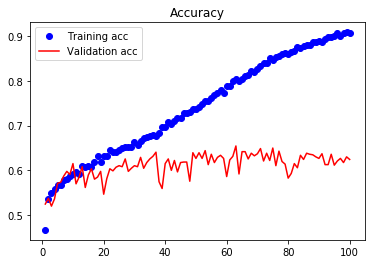

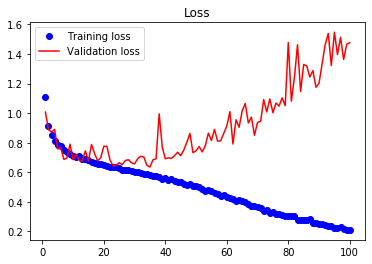

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [15]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [16]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 12.936, accuracy: 0.197, auc: 0.941, precision: 0.197, recall: 0.197, f1score: 0.197


In [17]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

859/859 [==============================] - 2s 3ms/step
loss: 1.476, accuracy: 0.624, auc: 0.941, precision: 0.623, recall: 0.622, f1score: 0.622


In [ ]:
myvgg.save('VGG16_Aug_1.h5')